# Get wallet portfolio

In [1]:
import os
import sys
import dotenv
import plotly.express as px
import pandas as pd

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from client.query_api_client import QuantNoteQueryApi

## Create Query Api Client


In [3]:
dotenv.load_dotenv(".env")
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = QuantNoteQueryApi(auth_token=AUTH_TOKEN, api_version="v1")
client

### Get Portfolio from API

Set variables used in the notebook

In [4]:
wallet = '0x90eB678C3586103805a676d21721Cc6883a6c3AE'
chain = {"name": 'eth', "id": 1}
# peg token id for given chain, it is used for portfolio for peg token which is represented as 0 in balances, but for price it nedd to be replaces with exact token ! 2 IS USED FOR ETH, FOR DIFFERENT CHAINS ITS DIFFERENT ID !
peg_token_id = 2

In [5]:
query = """SELECT token as token_id, COALESCE(*symbol('token', '{chain}', 'tokens'), 'ETH') as symbol, balance
from exchange.{chain}.series.balances
where wallet = wallet('{wallet}', {chain});""".format(chain=chain['name'], wallet=wallet)

portfolio = client.get_data_response(query)
portfolio['balance'] = pd.to_numeric(portfolio['balance'])
portfolio = portfolio.loc[portfolio['balance'] > 0]
portfolio['token_id'].replace(0, peg_token_id, inplace=True)   # Replace token_id=0 with peg_token_id because 0 is used for Eth balance but WETH token has token_id = 2... ! BE CAREFUL, FOR DIFFERENT CHAINS IS DIFFERENT VALUE !
portfolio

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,balance,symbol,token_id
0,1.203425e+03,ANT,1256
1,7.067730e+01,AAVE,616
2,4.637951e+06,AOA,3059
3,1.267043e+04,AST,1129
4,6.838568e+03,BAT,136
5,4.439705e+04,CHZ,1450
7,4.819710e+03,CRV,219
8,5.041655e+04,DATA,2500
9,5.775148e+03,ENJ,124
10,4.963117e+03,FET,1716


Get Prices for tokens from portfolio

In [6]:
array_string = "({})".format(', '.join(map(str, portfolio['token_id'].to_numpy())))
price_query = """SELECT token_id, price
FROM intelligence.stats
WHERE token_id in {tokens}
and chain = {chain_id}""".format(tokens=array_string, chain_id=chain['id'])

prices = client.get_data_response(price_query)
prices['price'] = pd.to_numeric(prices['price'])
prices

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,price,token_id
0,1675.197589,2
1,1.000987,3
2,0.581449,6
3,7.257949,7
4,1.001276,8
5,0.000012,14
6,1.237710,22
7,0.056933,63
8,1.445144,95
9,0.373384,110


Merge prices with portfolio (inner join, so exclude tokens that has no price - it often means that are not active)

In [7]:
merged = portfolio.merged = pd.merge(portfolio, prices, on=["token_id"])
merged

/tmp/ipykernel_1890/3485115685.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  merged = portfolio.merged = pd.merge(portfolio, prices, on=["token_id"])


,balance,symbol,token_id,price
0,1.203425e+03,ANT,1256,3.249989
1,7.067730e+01,AAVE,616,90.949226
2,1.267043e+04,AST,1129,0.108818
3,6.838568e+03,BAT,136,0.275521
4,4.439705e+04,CHZ,1450,0.147072
5,4.819710e+03,CRV,219,1.071350
6,5.041655e+04,DATA,2500,0.035475
7,5.775148e+03,ENJ,124,0.478142
8,4.963117e+03,FET,1716,0.293890
9,4.991053e+04,FTM,6,0.581449


Count balances value in USD

In [8]:
merged['usd_value'] = merged['balance']*merged['price']
merged

,balance,symbol,token_id,price,usd_value
0,1.203425e+03,ANT,1256,3.249989,3911.118243
1,7.067730e+01,AAVE,616,90.949226,6428.045487
2,1.267043e+04,AST,1129,0.108818,1378.772947
3,6.838568e+03,BAT,136,0.275521,1884.166701
4,4.439705e+04,CHZ,1450,0.147072,6529.557401
5,4.819710e+03,CRV,219,1.071350,5163.597673
6,5.041655e+04,DATA,2500,0.035475,1788.547668
7,5.775148e+03,ENJ,124,0.478142,2761.343583
8,4.963117e+03,FET,1716,0.293890,1458.611440
9,4.991053e+04,FTM,6,0.581449,29020.416343


In [9]:
print(f"Total value in USD is: {merged['usd_value'].sum()}.")

Total value in USD is: 600235.7264255881.


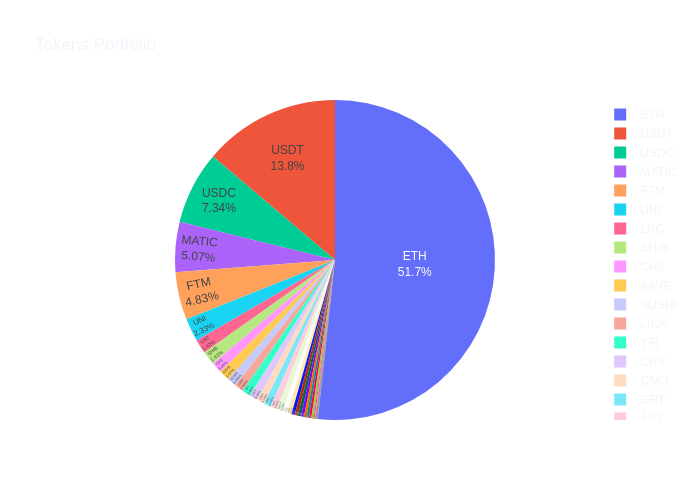

In [10]:
fig = px.pie(merged, values='usd_value', names='symbol',
             title='Tokens Portfolio')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show("png")